In [18]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [19]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [20]:
df = pd.read_csv("data/my_horizon_data_all.csv", dtype={"subject": str})


# files = [
#     "data/my_horizon_data.csv",
#     "data/my_horizon_data_0919.csv",
# ]
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [21]:
df

,subject,block,m1,m2,uc,gameLength,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,0,0,40,36,1,6,18,-99,0,42,...,184.143661,4.635614,1.122532,2.833540,2.738855,5.263696,5.763985,1.940346,0.937745,2.472841
1,0,1,60,48,0,6,18,-99,0,67,...,1.184903,1.013671,1.305989,8.874533,2.708196,2.426142,1.115581,1.370487,1.103393,1.046302
2,0,2,40,36,0,6,18,-99,0,37,...,0.832413,0.468084,0.566725,0.445963,1.810017,1.325654,0.892086,0.780645,1.881181,0.576540
3,0,3,40,48,0,1,18,-99,0,58,...,0.830383,0.553779,0.817720,1.686227,0.910277,NaN,NaN,NaN,NaN,NaN
4,0,4,40,10,0,1,18,-99,0,4,...,0.663673,1.049479,0.692706,3.581879,4.616839,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170980,1032.0_TMS,155,39,35,-1,6,21,1,0,29,...,-99.000000,-99.000000,-99.000000,-99.000000,0.250419,0.250419,0.417128,0.283480,0.450473,0.316901
170981,1032.0_TMS,156,59,51,0,1,21,1,0,69,...,-99.000000,-99.000000,-99.000000,-99.000000,0.383629,NaN,NaN,NaN,NaN,NaN
170982,1032.0_TMS,157,63,63,0,1,21,1,0,61,...,-99.000000,-99.000000,-99.000000,-99.000000,0.217306,NaN,NaN,NaN,NaN,NaN
170983,1032.0_TMS,158,41,31,-1,1,21,1,0,40,...,-99.000000,-99.000000,-99.000000,-99.000000,0.150339,NaN,NaN,NaN,NaN,NaN


In [22]:
num_subjects = df["subject"].nunique()
print("Number of unique subjects:", num_subjects)

Number of unique subjects: 1384


In [23]:
# same as sklearn 

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

# only keep the first trial per subject
print(f"Original df shape: {df.shape}")
df = df.groupby('subject').head(1).reset_index(drop=True) # first trial only
print(f"New df shape: {df.shape}")

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)



# X_seq_train = X_seq_train.to_numpy()
# X_seq_test = X_seq_test.to_numpy()
# X_static_train = X_static_train.to_numpy()
# X_static_test = X_static_test.to_numpy()

print("After scaling:")
print(f'X_seq_train {X_seq_train[0]}')
print(f'X_static_train {X_static_train[0]}')
print(f'y_train {y_train.iloc[0]}')

Original df shape: (170985, 44)
New df shape: (1384, 44)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
1  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
2  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
3  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
4  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
   gameLength  uc
0           6   1
1           6   1
2           6   1
3           6   1
4           6   1

--- Target Data (y) ---
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: c4, dtype: float64
After scaling:
X_seq_train [ 0.2014224   1.01731336  0.36230168  0.9125686  -0.43560714 -1.14081344
  0.59467461  1.01547657]
X_static_train [0.90428645 1.16780361]
y_train 1.0


In [24]:
SEQ_LEN = seq_features.__len__() // 4 
print(f"SEQ_LEN: {SEQ_LEN}")

SEQ_LEN: 2


In [25]:
feature_order_test = np.array(seq_features).reshape(-1, 4, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [26]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(1107, 8)
(277, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [27]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)
print(X_seq_test.shape)
print(type(X_seq_test))

(1107, 4, 2)
<class 'numpy.ndarray'>
[[ 0.2014224   1.01731336]
 [ 0.36230168  0.9125686 ]
 [-0.43560714 -1.14081344]
 [ 0.59467461  1.01547657]]
(277, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [28]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [29]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [30]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [31]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [32]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# running experiment

In [33]:
from utils.models import (
    RNN,
    LSTM,
    GRU,
    TinyGRU,
    TransformerEncoderPositionalEncoding,
    SelfAttentionOnly,
)
from utils.train_eval import train_and_evaluate

In [34]:
model_dict = {
    "RNN": RNN(SEQ_LEN).to(device),
    "LSTM": LSTM(SEQ_LEN).to(device),
    "GRU": GRU(SEQ_LEN).to(device),
    "TinyGRU": TinyGRU(SEQ_LEN).to(device),
    "Transformer": TransformerEncoderPositionalEncoding(SEQ_LEN).to(device),
    "Self-Attention": SelfAttentionOnly(SEQ_LEN).to(device),
    # "TinyAttentionNoProj": TinyAttentionNoProj(SEQ_LEN).to(device),
}

In [36]:
epochs = 100
test_loaders = (test_loader, test_loader_h1, test_loader_h6)
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(model, train_loader, test_loaders, criterion, optimizer, device, epochs=epochs)
    model_dict[model_name] = {
        "model": model,
        **history
    }



Training model: RNN
Epoch 1: Loss: 0.6694 | overall: 0.6101 | H1 0.5841 | H6 0.6280
Epoch 10: Loss: 0.5495 | overall: 0.7509 | H1 0.8230 | H6 0.7012
Epoch 20: Loss: 0.5415 | overall: 0.7545 | H1 0.8142 | H6 0.7134
Early stopping triggered: epoch 29 best_loss 0.5167

Training model: LSTM
Epoch 1: Loss: 0.6842 | overall: 0.5921 | H1 0.5752 | H6 0.6037
Epoch 10: Loss: 0.5550 | overall: 0.7220 | H1 0.7522 | H6 0.7012
Epoch 20: Loss: 0.5499 | overall: 0.7473 | H1 0.8053 | H6 0.7073
Early stopping triggered: epoch 20 best_loss 0.5448

Training model: GRU
Epoch 1: Loss: 0.6799 | overall: 0.5993 | H1 0.6018 | H6 0.5976
Epoch 10: Loss: 0.5345 | overall: 0.7509 | H1 0.8053 | H6 0.7134
Epoch 20: Loss: 0.5319 | overall: 0.7726 | H1 0.8407 | H6 0.7256
Epoch 30: Loss: 0.5295 | overall: 0.7726 | H1 0.8319 | H6 0.7317
Early stopping triggered: epoch 30 best_loss 0.5281

Training model: TinyGRU
Epoch 1: Loss: 0.7266 | overall: 0.4874 | H1 0.5310 | H6 0.4573
Epoch 10: Loss: 0.6483 | overall: 0.6282 | H

In [37]:
dump_history = {}

for model_name, content in model_dict.items():
    # content = {"model": <model_object>, "train_acc": ..., "test_acc": ..., ...}
    filtered = {k: v for k, v in content.items() if k != "model"}
    dump_history[model_name] = filtered
# store the outputs 
import json
with open("output_first_trial.json", "w") as f:
    json.dump(dump_history, f)

# plotting

In [38]:
import importlib
import utils.plotting as plotting
importlib.reload(plotting)

from utils.plotting import plot_test_loss, plot_error_bars

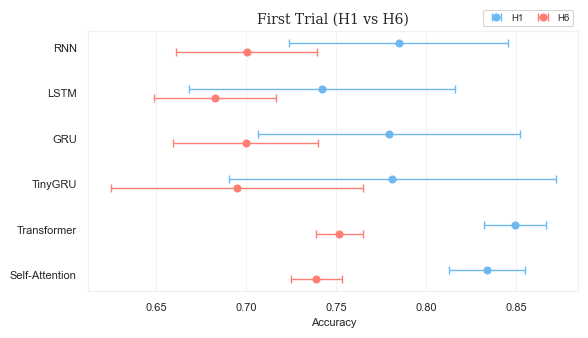

In [39]:
plot_error_bars(model_dict, title="First Trial (H1 vs H6)")